# Natural Language Processing

NLP Credit: Yang Bo

Github Repo Link: https://github.com/Beau-Yang/CS5242-Group18

## 1. Exploratory Data Analysis And Data Pre-processing

**Exploratory Data Analysis (EDA)** and **Data Pre-processing** are the two critical steps before starting to analysis data with deep learning. Exploratory Data Analysis performs the initial analysis which allows us to achieve overall understanding on the dataset and the relationship between variables while the data preproceesing helps to clean and enhance the raw dataset to make it ready for the further steps.

Generally, EDA and data pre-processing are mutually influenced and alternated in the early stage of data analysis.

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import json

In [ ]:
# read the corespondence between id and genre
with open("drive/MyDrive/Project/data_NLP/genre_id_info.txt", "r") as f:
    content = json.loads(f.read())
    id2genre = {str(i["id"]): i["name"] for i in content}
    id2genre = dict(sorted(id2genre.items(), key=lambda x: int(x[0])))

data = pd.DataFrame(columns=["id", "genre_ids", "overview"])

for key in id2genre.keys():
    data_temp = pd.read_csv(
        f"drive/MyDrive/Project/data_NLP/{key}.csv",
        sep=",",
    )
    data = pd.concat([data, data_temp[["id", "genre_ids", "overview"]]], axis=0)

data = data.convert_dtypes()
num_data = data.shape[0]
print(f"Dataset Original Shape: {data.shape}")

Dataset Original Shape: (114000, 3)


### 1.1. Data Cleaning

Fist of all, we need to clean the raw dataset. Common methods of data preprocessing include removing duplicate records, handling missing values, processing outliers and so on.

In [ ]:
# 1. drop duplicates
data.drop_duplicates(subset="id", inplace=True, ignore_index=True)
data.drop_duplicates(subset="overview", inplace=True, ignore_index=True)

print(f"Num of Duplicates: {num_data - data.shape[0]}; Current Dataset Shape is {data.shape}", end="\n\n")
num_data = data.shape[0]

# 2. remove missing values
print(f"Missing Data:\n{data.isna().sum()}")
data.dropna(inplace=True)
data = data[~(data["genre_ids"] == "[]")]
data = data[~(data["overview"] == "No overview found.")]

print(f"Number of Missing Data: {num_data - data.shape[0]}; Current Dataset Shape: {data.shape}", end="\n\n")
num_data = data.shape[0]

# 3. discard too short overviews (which may include missing values like 'unknown overview')
print(f"Overview Description:\n{data['overview'].str.len().describe()}")
data = data[data["overview"].str.len() >= 50]
print(f"Number of Short Overviews: {num_data - data.shape[0]}; Current Dataset Shape: {data.shape}")

Num of Duplicates: 45908; Current Dataset Shape is (68092, 3)

Missing Data:
id           0
genre_ids    0
overview     1
dtype: int64
Number of Missing Data: 8; Current Dataset Shape: (68084, 3)

Overview Description:
count    68084.000000
mean       297.508357
std        186.226596
min          1.000000
25%        154.000000
50%        248.000000
75%        395.000000
max       1000.000000
Name: overview, dtype: float64
Number of Short Overviews: 715; Current Dataset Shape: (67369, 3)


Given that one movie may belong to multiple genres, we need to split the `genre_ids` attribute into different columns where a value of 1 means that the movie belongs to the genre and 0 means that it does not.


In [ ]:
for id in id2genre.keys():
    data[id] = data["genre_ids"].map(lambda x: 1 if id in x else 0)
data_original = data.copy(deep=True)
print(data.head())

       id        genre_ids                                           overview  \
0  436270     [28, 12, 14]  Nearly 5,000 years after he was bestowed with ...   
1  960704     [28, 12, 14]  The Elric brothers’ long and winding journey c...   
2  791155    [878, 12, 28]  While hanging out after school, Charlie and hi...   
3  759507     [28, 12, 53]  A man wakes in a hospital with no memory, and ...   
4  532639  [14, 12, 10751]  A wooden puppet embarks on a thrilling adventu...   

   12  14  16  18  27  28  35  ...  53  80  99  878  9648  10402  10749  \
0   1   1   0   0   0   1   0  ...   0   0   0    0     0      0      0   
1   1   1   0   0   0   1   0  ...   0   0   0    0     0      0      0   
2   1   0   0   0   0   1   0  ...   0   0   0    1     0      0      0   
3   1   0   0   0   0   1   0  ...   1   0   0    0     0      0      0   
4   1   1   0   0   0   0   0  ...   0   0   0    0     0      0      0   

   10751  10752  10770  
0      0      0      0  
1      0    

Now, we can try to "take a peek" at the data to understand more about what it represents and how to apply it.


### 1.2. Distribution of Data

Firstly we can have a look at the labels of data and their corresponding IDs.

In [ ]:
print(f"Number of Labels: {len(id2genre)}")
for k, v in id2genre.items():
    print(f"{k}: {v}", end="; ")

Number of Labels: 19
12: Adventure; 14: Fantasy; 16: Animation; 18: Drama; 27: Horror; 28: Action; 35: Comedy; 36: History; 37: Western; 53: Thriller; 80: Crime; 99: Documentary; 878: Science Fiction; 9648: Mystery; 10402: Music; 10749: Romance; 10751: Family; 10752: War; 10770: TV Movie; 

Then we want to check the number of movies in each genre to make sure that the number does not vary much, as a result of which, we don't have to worry about the imbalanced classification problem too much. The pie chart is one of the common ways to visualize the composition ratio while the tree map can demonstrate the relationship between the magnitude of the quantities more clearly.

The pie chart and tree map of the number are shown as below. And it turns out that numbers are relatively even.

In [ ]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


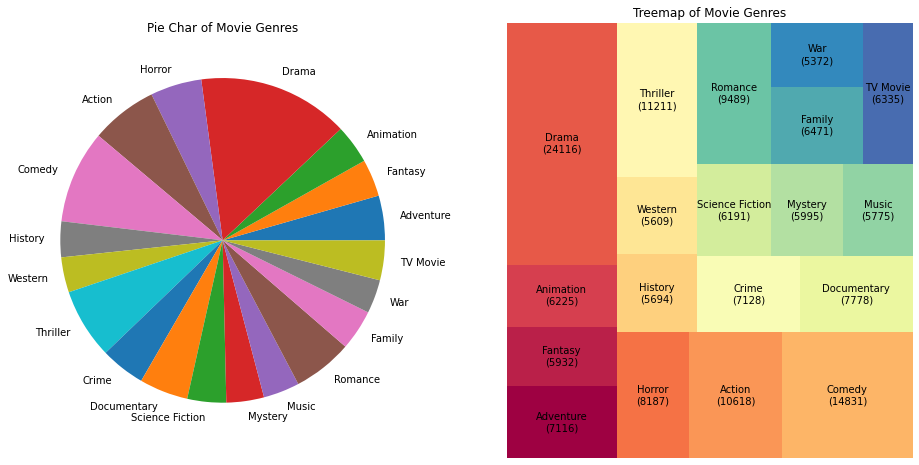

In [ ]:
import matplotlib.pyplot as plt
import squarify

data_sum = data[[str(i) for i in id2genre.keys()]].sum().reset_index(name="counts")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pie(data_sum["counts"], labels=id2genre.values())
plt.title("Pie Char of Movie Genres")

plt.subplot(122)
squarify.plot(
    sizes=data_sum["counts"].values.tolist(),
    label=data_sum.apply(lambda x: f"{id2genre[x[0]]}\n({x[1]})", axis=1),
    color=[plt.cm.Spectral(i / float(len(id2genre))) for i in range(len(id2genre))],
)
plt.title("Treemap of Movie Genres")
plt.axis("off")
plt.show()

Obviously one movie may have multiple genres. Now let's see the number of labels per movie.

In [ ]:
data["num"] = data[id2genre.keys()].sum(axis=1)
data["num"].describe()

count    67369.000000
mean         2.376063
std          1.032481
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: num, dtype: float64

We can see that, most of movies only have at most 2 genres which means the label will be very **sparse** if we use all genres without selection. That makes it very hard for the model to learn because models will just predict all tags to 0 which has very low loss and very high accuracy (which I already tried on the multi-class multi-label classification problem). So we decide to select the 5 genres as the label to do the classification problem. Meanwhile, the size of dataset is expected to be as large as possible.

Let's first have a look at those recordings with only one genre.

In [ ]:
movie_one = data[data["num"] == 1]
for i in id2genre.keys():
    print(f"{i}: {movie_one[movie_one[i] == 1].shape[0]}")

12: 145
14: 147
16: 810
18: 860
27: 1152
28: 289
35: 892
36: 181
37: 3020
53: 287
80: 132
99: 3892
878: 365
9648: 126
10402: 1110
10749: 235
10751: 179
10752: 309
10770: 35


The most genre is "Documentary"(99) and the number is 3892 which is very small. So we need to find the combination of genres which one movie only belongs to one of them.

In [ ]:
from itertools import permutations

# sort id according to the frequency
ids = data_sum.sort_values(by="counts", ascending=False)["index"].tolist()
# generator of combination
perms = (i for i in permutations(ids, 5))

def get_genre(series, perm):
    for i, j in zip(series.index, series):
        if (i in perm) and (j == 1):
            return i

# find the maximum minimum count
count_min = 0
for perm in perms:

    data_temp = data[data[list(perm)].sum(axis=1) == 1][list(perm)]

    data_temp["genre"] = data_temp.apply(lambda x: get_genre(x, perm), axis=1)
    data_temp_count = data_temp["genre"].value_counts()
    if count_min < data_temp_count.min():
        count_min = data_temp_count.min()
        print(f"Perm: {perm}, Min Count: {count_min}")

        if 5000 - count_min <= 10:
            break

Perm: ('18', '35', '53', '28', '10749'), Min Count: 1347
Perm: ('18', '35', '53', '28', '27'), Min Count: 2331
Perm: ('18', '35', '53', '28', '99'), Min Count: 4158
Perm: ('18', '35', '28', '27', '99'), Min Count: 4994


In [ ]:
perm = ('18', '35', '28', '27', '99')
for i in perm:
    print(f"{id2genre[i]}", end=" ")
print()

data = data[data[list(perm)].sum(axis=1) == 1][list(perm) + ["overview"]]
data["genre"] = data.apply(lambda x: get_genre(x, perm), axis=1)
id2genre = {i: id2genre[i] for i in perm}

movies = None
for i in perm:
    data_temp = data[data["genre"] == i][:5000]
    if movies is None:
        movies = data_temp.copy(deep=True)
    else:
        movies = pd.concat([movies, data_temp.copy(deep=True)], ignore_index=True)
print(movies["genre"].value_counts())

Drama Comedy Action Horror Documentary 
18    5000
35    5000
28    5000
99    5000
27    4994
Name: genre, dtype: int64


We can see that the combination is "Drama", "Comedy", "Action", "Horror" and "Documentary". To balance the number of different labels, around 5000 samples of every genre are selected.

### 1.3. Word Frequency

In terms of the NLP task, we want to predict the movie genres using its overview. It's natural to check the word frequency so we can have a better understanding of the overview contents.

But we need to process these text data before that.

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import nltk

nltk.download('stopwords')

def clean_text(text):
    # 1. lowcase
    text = text.lower()

    # 2. convert short form of words
    for i, j in [("won't", "will not"), ("'t", " not"), ("'re", " are"), ("'s", " is"), \
        ("'d", " would"), ("'ll", " will"), ("'ve", " have"), ("'m", " am")]:
        text = re.sub(i, j, text)
    
    # 3. remove all punctuations
    text = re.sub("[^a-zA-Z]", " ", text)

    return text

# 4. remove STOPWORDS
def sw(text):    
    text = " ".join([word for word in text.split() if word not in nltk.corpus.stopwords.words('english')])
    return text

data["text"] = data["overview"].apply(lambda x: clean_text(x))
data["text_sw"] = data["text"].apply(lambda x: sw(x))
print(f"Original Text: {data['overview'][0]}\n\nProcessed Text: {data['text'][0]}\n\nProcessed Text (Stopwords): {data['text_sw'][0]}")

data[list(perm) + ["text"]].to_csv("drive/MyDrive/Project/data_NLP/data.csv", sep=",", index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Original Text: Nearly 5,000 years after he was bestowed with the almighty powers of the Egyptian gods—and imprisoned just as quickly—Black Adam is freed from his earthly tomb, ready to unleash his unique form of justice on the modern world.

Processed Text: nearly       years after he was bestowed with the almighty powers of the egyptian gods and imprisoned just as quickly black adam is freed from his earthly tomb  ready to unleash his unique form of justice on the modern world 

Processed Text (Stopwords): nearly years bestowed almighty powers egyptian gods imprisoned quickly black adam freed earthly tomb ready unleash unique form justice modern world


 The steps of proceesing include lowcase, removal punctuations and convertion short forms removal stopwords so we can focus on those more important words if we remove them from the text. 

 Have a look at the stopwords.

In [ ]:
print(f"Common Words: {', '.join(nltk.corpus.stopwords.words('english'))}")

Common Words: i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn'

In this section, we find the 80 most frequent words of all collected overviews and then delete the common words in it because they may not make much sense. The bar plot of word frequency is shown as below.


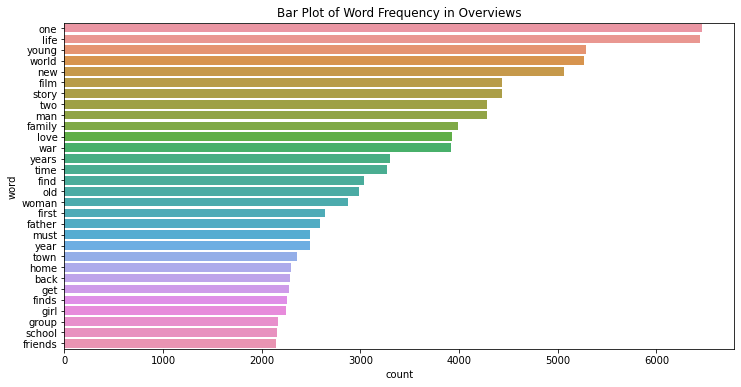

In [ ]:
import nltk
import seaborn as sns

content = " ".join(data["text_sw"])
fdist = nltk.FreqDist(content.split())
words_df = pd.DataFrame({"word": list(fdist.keys()), "count": list(fdist.values())})

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=words_df.nlargest(columns="count", n=30), x="count", y="word")
ax.set(title="Bar Plot of Word Frequency in Overviews")
plt.show()

As we can see in the plot, the most frequent words consist of the words relating to the main characters and the theme of movies. Specifically, **one**, **two** and other quantifiers are used to indicate the number of main characters generally; **young**, **man** and **girl** are used to indicate their characteristics (gender, age and etc.) while **love**, **world** and **war** are in connection with the movie themes. According to the definition, "film genres are usually delineated by '_conventions_, _iconography_, _settings_, _narratives_, _characters_ and _actors_.'" Given that the overview contains these factors, we believe that it’s viable to predict the movie genre utilizing its plot overview.

A short example is shown as below which consists of "war", "one" and "man" as mentioned before:


In [ ]:
print(data["overview"][69])

As a collection of history's worst tyrants and criminal masterminds gather to plot a war to wipe out millions, one man must race against time to stop them.


### 1.4. Word Cloud

In this section, we want to draw the word cloud graphs for every movie genre and see whether the most frequent words can reflect the characteristics of different genres.


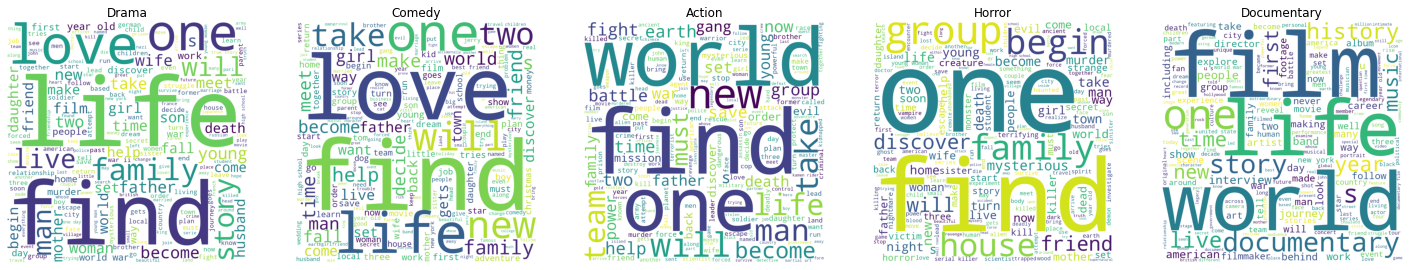

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize=(25, 5))

for i, (id, value) in enumerate(id2genre.items()):

    plt.subplot(1, 5, i + 1)
    content = "".join(data[data[id] == 1]["overview"]).lower()
    word_cloud = WordCloud(width=1000, height=1000, background_color="white").generate(
        content
    )
    plt.imshow(word_cloud)
    plt.title(value)
    plt.axis("off")

plt.show()

Other than the common words like "find" and "life", the most frequent words do have to do with genres.

For example, with regard to the "Action" movies, **team** and **time** are two of the most frequent words while 
the protagonists form a team to complete the task in a limited amount of time in this kind of movies, like: James Bond series. In addition, **house** is one of common scenes in the "Horror" movies like: The Shining. As to the "Documentary" ones, it's easy to understand that **history** is the common word because the content of this kind of movies is usually related to the history event.

All in all, it looks reasonable to use the overview to predict the genre of movies.


### 1.5. Correlation Heatmap

In this section, we are intended to check the correlation between different genres to make sure that genres are not too similar to effect the classifcation performance.

First of all, we check the number of frequency of simultaneous appearance of different genres so we can have a look at the relationship between the attributes roughly but visually.

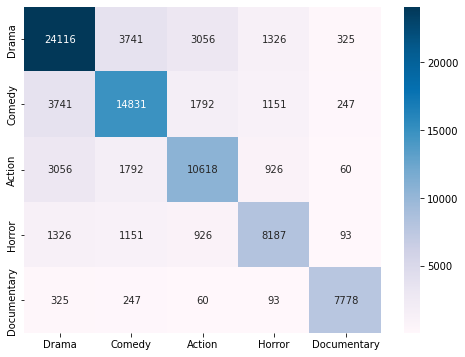

In [ ]:
import seaborn as sns

data_genres = data_original[id2genre.keys()]

genre_count = []
for i in id2genre.keys():
    temp_count = []
    for j in id2genre.keys():
        temp_count.append(
            data_genres[(data_genres[i] == 1) & (data_genres[j] == 1)].shape[0]
        )
    genre_count.append(temp_count)

plt.figure(figsize=(8, 6))

sns.heatmap(
    pd.DataFrame(genre_count),
    xticklabels=id2genre.values(),
    yticklabels=id2genre.values(),
    annot=True,
    cmap="PuBu",
    fmt="d",
)
plt.show()

As we can see in the heatmap, the value in the *i*-th row, *j*-th col indicates the number of movies belonging to both the *i*-th and *j*-th genres.

We can get some interesting insights from the heatmap, for example, there are 3741 movies that belongs to "Drama" and "Comedy" while there are 24116 "Drama" moives and 14831 "Comedy" moives. That's easy to understand: Drama movies tend to encourage a broader range of moods which contains humor.  As a result, we need to further determine whether the different genres will be too similar in terms of statistical significance.

Because these genre attributions are categorical (binary) variable instead of numeric variables, the common Pearson correlation coefficient doesn't make much sense which is used to reflect the linear correlation between variables. And we choose to use the Cramér's V here to measure the association between nominal variables.

Max Value: 0.23819978477992368, Min Value: 0.04520099671924724


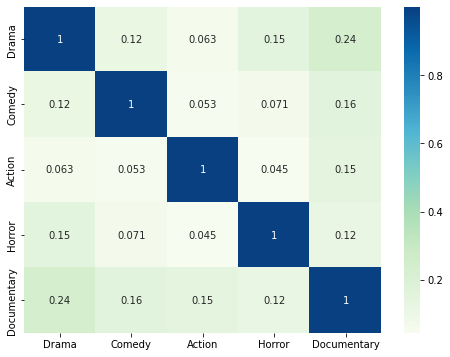

In [ ]:
from scipy.stats import chi2_contingency
import numpy as np


def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


data_corr = []
max_corr, min_corr = -np.inf, np.inf

for i in id2genre.keys():
    temp = []
    for j in id2genre.keys():
        value = cramers_v(data_genres[i], data_genres[j])
        temp.append(value)
        if i != j:
            max_corr = max(max_corr, value)
            min_corr = min(min_corr, value)
    data_corr.append(temp)



print(f"Max Value: {max_corr}, Min Value: {min_corr}")

plt.figure(figsize=(8, 6))
sns.heatmap(
    pd.DataFrame(data_corr),
    xticklabels=id2genre.values(),
    yticklabels=id2genre.values(),
    annot=True,
    cmap="GnBu",
)
plt.show()

As we can see from the result, the maximum value is around 0.24 which is related to the Drama and Documentary. It is small so we can think all these genres are not independent from each other.

## 2. NLP Models

After performing pre-processing and exploratory data analysis on the data, we can now start to prepare for model training.


In [ ]:
import pandas as pd
import json
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import time
from tqdm.notebook import trange
import math
import matplotlib.pyplot as plt
import copy
import random

# load id2genre & data
data = pd.read_csv("drive/MyDrive/Project/data_NLP/data.csv", sep=",").convert_dtypes()

with open("drive/MyDrive/Project/data_NLP/genre_id_info.txt", "r") as f:
    content = json.loads(f.read())
    id2genre = {str(i["id"]): i["name"] for i in content if str(i["id"]) in data.columns[:5]}
    id2genre = dict(sorted(id2genre.items(), key=lambda x: int(x[0])))

In [ ]:
# set random seed
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### 2.1. Prepare Data

AI models can not learn from the text data directly, so we need to further process it to make it ready for the training.

We perform text tokenizer here to vectorize a text corpus, by turning each text into a sequence of integers based on word count where the integer is the index of a token in a dictionary.

Firstly, we build the dictionary based on the word frequency of overviews. In this step, we don't save all words because some words may only exist few times which do not make much sense. Then we truncate the longer sequences and pad the shorter ones to let all vectors keep the same length.


In [ ]:
from torchtext.data import get_tokenizer
from torchtext.vocab import vocab
from collections import Counter, OrderedDict
import torchtext.transforms as T
from torch.utils.data import DataLoader

text = " ".join(data["text"])
tokenizer =  get_tokenizer("basic_english")
tokens = tokenizer(text)

# token frequency
counter = Counter(tokens)
freq_dist = OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
# <unk>: 0, <pad>: 1, <bos>: 2, <eos>: 3
voc = vocab(freq_dist, specials=['<unk>', '<pad>', '<bos>', '<eos>'], min_freq=100, special_first=True) 
voc.set_default_index(0)

# remove non-english overviews
data[data["text"].apply(lambda x: len(tokenizer(x))) > 0]

# transform pipeline
text_transform = T.Sequential(
    T.VocabTransform(voc),
    T.Truncate(48),
    T.AddToken(token=2, begin=True),
    T.AddToken(token=3, begin=False),
)

We create a custom dataset to load the data. Each item is a pair of overview and genre labels.

The whole dataset is divided into three parts according their usage: train (70%), test (20%) and validation (10%).


In [ ]:
class OverviewDataset(Dataset):
    def __init__(self, data_split):
        super().__init__()
        self.X = T.ToTensor(padding_value=1)([i for i in data_split["text"].apply(lambda x: text_transform(tokenizer(x)))])
        self.Y = torch.tensor(np.array((data_split[id2genre.keys()]), dtype=int))

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

num = len(data)
data = data.sample(frac=1)
train_data = OverviewDataset(data[:int(num * 0.7)])
valid_data = OverviewDataset(data[int(num * 0.7):int(num * 0.8)])
test_data = OverviewDataset(data[int(num * 0.8):])

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

/usr/local/lib/python3.7/dist-packages/torch/_jit_internal.py:1138: UserWarning: The inner type of a container is lost when calling torch.jit.isinstance in eager mode. For example, List[int] would become list and therefore falsely return True for List[float] or List[str].
  warnings.warn("The inner type of a container is lost when "


Take a look at the each item of the dataset for training.


In [ ]:
sample_X, sample_Y = next(iter(train_dataloader))
print(f"Feature Shape: {sample_X.shape}, Label Shape: {sample_Y.shape}\nFeature Data:\n{sample_X[0]}\nLabel Data: {sample_Y[0]}")

Feature Shape: torch.Size([64, 50]), Label Shape: torch.Size([64, 5])
Feature Data:
tensor([   2,   10,  630,  684, 1080,  636,    0,  368,   18,   14,   31,    0,
           5,    0, 1053,   10,    0,   23,   11,  719,    0, 2377,    0,   14,
          11,  357, 1212,    6,   13,    0,  115,    0,  349,    0,    8,  364,
        1216,    8,  156,   10,    4, 1876,  111,    8, 1464,   29,   26,   24,
          27,    3])
Label Data: tensor([0, 1, 0, 0, 0])


### 2.2. Code Framework

To facilitate experimentation with different models and parameters, we write a simple code framework to modularized individual parts of the common AI training and testing flow.

In [ ]:
# use "records" to record the training history of different models
records = dict()
record_default = {
    "train_loss": [], 
    "train_acc": [], 
    "valid_loss": [], 
    "valid_acc": [], 
    "test_loss": 0, 
    "test_acc": 0
}

In this task, we choose the **accuracy** evaluation metric to show the performance of model given that the numbers of movies belonging to different genres are balanced and every class is equally important.

Accuracy measures how many observations, both positive and negative, were correctly classified.

$$
\text{Acc} = \dfrac{TP + TN}{TP + FP + TN + FN}
$$

We define its function to compute the prediction accuracy to show the model performance in the process of training.

In [ ]:
# compute the prediction accuracy
def accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / correct.shape[0] / correct.shape[1]
    return acc

In [ ]:
# plot loss and acc curve of train and test
def plot(num_epoch, name, type):

    plt.plot(range(num_epoch), records[name]["train_" + type], label=f"train {type}")
    plt.plot(range(num_epoch), records[name]["valid_" + type], label=f"valid {type}")
    plt.title(f"{name} {type}")
    plt.legend()
    plt.show()

Then, we define the function of running models which includes training and validation in every epoch and testing in the end. In this process, we save the parameters of the best model and record the loss and accuracy of every epoch.

In [ ]:
def run_epoch(network, criterion, optimizer, paras, run, record_bool=True, plot_bool=True):

    valid_best_loss = float("inf")
    start = time.time()

    for epoch in trange(paras["num_epoch"]):

        train_loss, train_acc = run(network, train_dataloader, criterion, optimizer, paras, True)
        valid_loss, valid_acc = run(network, valid_dataloader, criterion, optimizer, paras, False)

        # save the best model
        if valid_loss < valid_best_loss:
            valid_best_loss = valid_loss
            torch.save(network.state_dict(), f"drive/MyDrive/Project/model_NLP/{paras['name']}.pt")
        
        if record_bool:
            print(f"Epoch: {epoch}, Time: {time.time() - start:.2f}; Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2%}; Valid Loss: {valid_loss:.3f}, Valid Acc: {valid_acc:.2%}")

        # record loss and acc of train and test
        records[paras['name']]["train_loss"].append(train_loss)
        records[paras['name']]["train_acc"].append(train_acc)
        records[paras['name']]["valid_loss"].append(valid_loss)
        records[paras['name']]["valid_acc"].append(valid_acc)

    # load the best model
    network.load_state_dict(torch.load(f"drive/MyDrive/Project/model_NLP/{paras['name']}.pt"))
    test_loss, test_acc = run(network, test_dataloader, criterion, optimizer, paras, False)
    print(f"Time: {time.time() - start:.2f}, Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2%}")
    records[paras['name']]["test_loss"] = test_loss
    records[paras['name']]["test_acc"] = test_acc

    # plot the curve of loss and acc
    if plot_bool:
        plot(paras["num_epoch"], paras["name"], "loss")
        plot(paras["num_epoch"], paras["name"], "acc")

### 2.3. Models

Now, what we need to do is to define different models to process the NLP classification problem. In this part, we'll cover the models we use including its motivation, description, implementation, results and so on. It is worth noting in particular that we focus on the fundamental concepts of deep learning techniques instead of the performance so we only train the models for 25 epoches.

#### 2.3.1. Multi-Layer Perceptron

Multi-Layer Perceptron (MLP) is one of the most basic models which is simple and only consists of fully connected layers.

MLP.svg

In [ ]:
class MLP(nn.Module):

    def __init__(self, hidden_size, vocab_size, num_label):
        super(MLP, self).__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.fc1 = nn.Linear(50 * hidden_size, 2 * hidden_size)
        self.fc2 = nn.Linear(2 * hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_label)
        self.sm = nn.Softmax(dim=1)
    
    def forward(self, x):

        embed_seq = self.embedding(x)
        x1 = self.fc1(embed_seq.reshape(batch_size, -1))
        x2 = self.fc2(x1)
        x3 = self.fc3(x2)
        sig_out = self.sm(x3)

        return sig_out

In [ ]:
# define the train and test process
def run_MLP(model, dataloader, criterion, optimizer, paras, train):
    
    epoch_loss, epoch_acc = 0, 0

    if train:
        model.train()
        for X, Y in dataloader:

            X, Y = X.to(paras["device"]), Y.to(paras["device"])
            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y.float())
            acc = accuracy(output, Y)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.detach().item()
            epoch_acc += acc.detach().item()
    else:
        model.eval()
        with torch.no_grad():
            for X, Y in dataloader:

                X, Y = X.to(paras["device"]), Y.to(paras["device"])
                output = model(X)
                loss = criterion(output, Y.float())
                acc = accuracy(output, Y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

    # return the average loss and accuracy
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, Time: 1.36; Train Loss: 1.525, Train Acc: 76.09%; Valid Loss: 1.528, Valid Acc: 74.84%
Epoch: 1, Time: 2.71; Train Loss: 1.504, Train Acc: 75.78%; Valid Loss: 1.507, Valid Acc: 75.56%
Epoch: 2, Time: 4.06; Train Loss: 1.479, Train Acc: 77.16%; Valid Loss: 1.489, Valid Acc: 76.60%
Epoch: 3, Time: 5.39; Train Loss: 1.460, Train Acc: 78.26%; Valid Loss: 1.479, Valid Acc: 77.41%
Epoch: 4, Time: 6.75; Train Loss: 1.444, Train Acc: 79.05%; Valid Loss: 1.472, Valid Acc: 77.35%
Epoch: 5, Time: 8.07; Train Loss: 1.432, Train Acc: 79.61%; Valid Loss: 1.467, Valid Acc: 77.52%
Epoch: 6, Time: 9.41; Train Loss: 1.421, Train Acc: 80.08%; Valid Loss: 1.463, Valid Acc: 77.77%
Epoch: 7, Time: 10.77; Train Loss: 1.412, Train Acc: 80.41%; Valid Loss: 1.460, Valid Acc: 77.66%
Epoch: 8, Time: 12.10; Train Loss: 1.404, Train Acc: 80.70%; Valid Loss: 1.458, Valid Acc: 77.81%
Epoch: 9, Time: 13.44; Train Loss: 1.397, Train Acc: 81.02%; Valid Loss: 1.456, Valid Acc: 77.90%
Epoch: 10, Time: 14.75; Tra

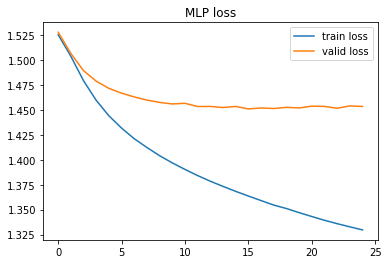

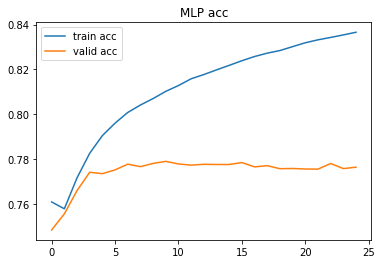

In [ ]:
# parameters
paras_MLP = {
    "name": "MLP",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-5,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
records[paras_MLP["name"]] = copy.deepcopy(record_default)

vocab_size = len(voc)
num_label = len(id2genre)

model = MLP(paras_MLP["hidden_size"], vocab_size, num_label).to(paras_MLP["device"])
criterion = nn.CrossEntropyLoss().to(paras_MLP["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=paras_MLP["learning_rate"])
run_epoch(model, criterion, optimizer, paras_MLP, run_MLP)

As we can see from the results, MLP is simple, fast but effective.

| Model | Test Loss | Test Accuracy | Training Time |
| :---: | :---: | :---: | :---: |
| MLP | 1.449 | 77.97% | 33.65 |


#### 2.3.2. Vanilla Recurrent Neural Network

When it comes to the text sequence data, the **Vanilla Recurrent Neural Network** (*RNN*) is one of the most used models. It is a neural network that uses recurrent computation for hidden states which is used to capture historical information of the sequence up to the current time step.

Before letting the RNN to learn from the sequences, we first need to perform word embedding to find the best possible representation of sequences. Compared to the one-hot encoding, it has lower dimension and is able to capture the meaning of words.

In [ ]:
class VRNN(nn.Module):

    def __init__(self, hidden_size, vocab_size, num_label, num_layers, bidirectional, dropout=0):
        super(VRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout) 
        self.fc = nn.Linear(hidden_size * (int(bidirectional) + 1), num_label)
        self.sm = nn.Softmax(dim=1)
    
    def forward(self, x, hidden):

        embed_seq = self.embedding(x)
        output, hidden = self.rnn(embed_seq, hidden)
        score = self.fc(output[:, -1, :])
        sig_out = self.sm(score)

        return sig_out, hidden

This is a simple demo for the VRNN architecture. We can see that the calculation of the hidden layer output of the current time step is determined by the input of the current time step together with the hidden layer output of the previous time step in VRNNs:

$$
H_{t} = \phi(X_{t}W_{xh} + H_{t-1}W_{hh} + b_{h})
$$

VRNN.svg

We use the VRNN recurrently by feeding in the current word as well as the hidden state from the previous word to produce the next hidden state. Once we have the final hidden state, we feed it through a linear layer.

Now, we can define the train and test function of VRNN. The difference between them is that we do not want to update weights when evaluating.

In [ ]:
# define the train and test process
def run_VRNN(model, dataloader, criterion, optimizer, paras, train):
    
    epoch_loss, epoch_acc = 0, 0
    h = torch.zeros(paras["num_layers"] * (int(paras["bidirectional"]) + 1), batch_size, paras["hidden_size"]).to(paras["device"])

    if train:
        model.train()
        for X, Y in dataloader:

            X, Y = X.to(paras["device"]), Y.to(paras["device"])
            optimizer.zero_grad()
            h = h.detach()

            output, h = model(X, h)
            loss = criterion(output, Y.float())
            acc = accuracy(output, Y)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.detach().item()
            epoch_acc += acc.detach().item()
    else:
        model.eval()
        with torch.no_grad():
            for X, Y in dataloader:

                X, Y = X.to(paras["device"]), Y.to(paras["device"])
                h = h.detach()
                output, h = model(X, h)
                loss = criterion(output, Y.float())
                acc = accuracy(output, Y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

    # return the average loss and accuracy
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

As to the loss function, we use `nn.CrossEntropyLoss()` which is a common loss function used in the classification problems.

After fine tuing the parameters, the results are shown as below.


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, Time: 2.68; Train Loss: 1.576, Train Acc: 78.89%; Valid Loss: 1.549, Valid Acc: 77.35%
Epoch: 1, Time: 5.33; Train Loss: 1.526, Train Acc: 75.96%; Valid Loss: 1.531, Valid Acc: 74.85%
Epoch: 2, Time: 7.20; Train Loss: 1.517, Train Acc: 75.49%; Valid Loss: 1.529, Valid Acc: 74.87%
Epoch: 3, Time: 9.00; Train Loss: 1.515, Train Acc: 75.50%; Valid Loss: 1.529, Valid Acc: 74.85%
Epoch: 4, Time: 10.78; Train Loss: 1.515, Train Acc: 75.50%; Valid Loss: 1.527, Valid Acc: 74.88%
Epoch: 5, Time: 12.58; Train Loss: 1.514, Train Acc: 75.50%; Valid Loss: 1.527, Valid Acc: 74.85%
Epoch: 6, Time: 14.38; Train Loss: 1.514, Train Acc: 75.50%; Valid Loss: 1.525, Valid Acc: 74.91%
Epoch: 7, Time: 16.17; Train Loss: 1.513, Train Acc: 75.50%; Valid Loss: 1.527, Valid Acc: 74.85%
Epoch: 8, Time: 17.97; Train Loss: 1.513, Train Acc: 75.50%; Valid Loss: 1.525, Valid Acc: 74.88%
Epoch: 9, Time: 19.78; Train Loss: 1.513, Train Acc: 75.53%; Valid Loss: 1.525, Valid Acc: 74.93%
Epoch: 10, Time: 21.64; 

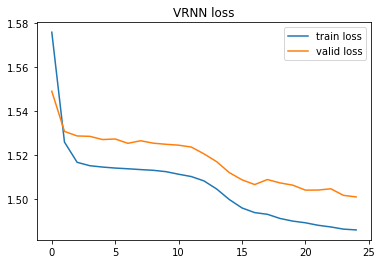

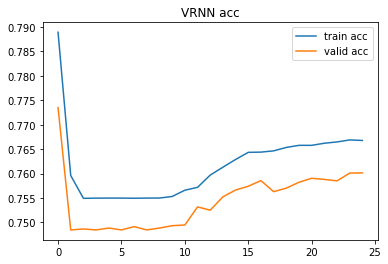

In [ ]:
# parameters
paras_VRNN = {
    "name": "VRNN",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-5,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "num_layers": 2,
    "bidirectional": False,
}
records[paras_VRNN["name"]] = copy.deepcopy(record_default)

vocab_size = len(voc)
num_label = len(id2genre)

model = VRNN(paras_VRNN["hidden_size"], vocab_size, num_label, paras_VRNN["num_layers"], paras_VRNN["bidirectional"]).to(paras_VRNN["device"])
criterion = nn.CrossEntropyLoss().to(paras_VRNN["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=paras_VRNN["learning_rate"])
run_epoch(model, criterion, optimizer, paras_VRNN, run_VRNN)

As we can see from the figures, the loss remains almost the same from the 5th epoch which means it's possible that the gradient almost vanishes at that point. It's one of the common problems happening in the RNN and the other one is the gradient exploding. It's hard for VRNNs to learn from long sequences (generally beyond 5-10 words), so we turn to those models which are less prone to the vanishing problem.

| Model | Test Loss | Test Accuracy | Training Time |
| :---: | :---: | :---: | :---: |
| MLP | 1.449 | 77.97% | 33.65 |
| VRNN | 1.496 | 76.21% | 50.69 |


#### 2.3.3. Long Short-Term Memory

**Long Short-Term Memory** (*LSTM*) networks resemble standard VRNNs but each ordinary recurrent node is replaced by a memory cell. Each memory cell contains two internal states: a short-term memory state and a long-term memory state ensuring that the gradient can pass across many time steps without vanishing or exploding.

In [ ]:
class LSTM(nn.Module):

    def __init__(self, hidden_size, vocab_size, num_label):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True) 
        self.fc = nn.Linear(hidden_size, num_label)
        self.sm = nn.Softmax(dim=1)
    
    def forward(self, x, h, c):
        
        embed_seq = self.embedding(x)
        output, (h, c) = self.rnn(embed_seq, (h, c))
        
        score = self.fc(output[:, -1, :])
        sig_out = self.sm(score)

        return sig_out, h, c

This is a simple demo for the LSTM architecture which consists of 4 parts:

1. Gates
 - Input Gate: $I_{t} = \sigma(X_{t}W_{xi} + H_{t-1}W_{hi} + b_{i})$
 - Forget Gate: $F_{t} = \sigma(X_{t}W_{xf} + H_{t-1}W_{hf} + b_{f})$
 - Output Gate: $O_{t} = \sigma(X_{t}W_{xo} + H_{t-1}W_{ho} + b_{o})$

2. Input Node: $\tilde{C_{t}} = \tanh{(X_{t}W_{xc} + H_{t-1}W_{hc} + b_{c})}$

3. Memory Cell Internal State: $C_{t} = F_{t} \odot C_{t-1} + I_{t} \odot \tilde{C_{t}}$

4. Hidden State: $H_{t} = O_{t} \odot \tanh(C_{t})$

LSTM.svg

In [ ]:
def run_LSTM(model, dataloader, criterion, optimizer, paras, train):
    
    epoch_loss, epoch_acc = 0, 0
    h = torch.zeros(1, batch_size, paras["hidden_size"]).to(paras["device"])
    c = torch.zeros(1, batch_size, paras["hidden_size"]).to(paras["device"])

    if train:
        model.train()
        for X, Y in dataloader:

            X, Y = X.to(paras["device"]), Y.to(paras["device"])
            optimizer.zero_grad()
            h = h.detach()
            c = c.detach()

            output, h, c = model(X, h, c)
            loss = criterion(output, Y.float())
            acc = accuracy(output, Y)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.detach().item()
            epoch_acc += acc.detach().item()
    else:
        model.eval()
        with torch.no_grad():
            for X, Y in dataloader:

                X, Y = X.to(paras["device"]), Y.to(paras["device"])
                h = h.detach()
                output, h, c = model(X, h, c)
                loss = criterion(output, Y.float())
                acc = accuracy(output, Y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, Time: 2.33; Train Loss: 1.534, Train Acc: 76.68%; Valid Loss: 1.527, Valid Acc: 74.86%
Epoch: 1, Time: 4.63; Train Loss: 1.509, Train Acc: 75.62%; Valid Loss: 1.514, Valid Acc: 75.65%
Epoch: 2, Time: 6.46; Train Loss: 1.495, Train Acc: 76.62%; Valid Loss: 1.498, Valid Acc: 76.23%
Epoch: 3, Time: 8.09; Train Loss: 1.481, Train Acc: 76.93%; Valid Loss: 1.494, Valid Acc: 76.30%
Epoch: 4, Time: 9.75; Train Loss: 1.464, Train Acc: 77.64%; Valid Loss: 1.472, Valid Acc: 77.16%
Epoch: 5, Time: 11.62; Train Loss: 1.447, Train Acc: 78.26%; Valid Loss: 1.467, Valid Acc: 77.41%
Epoch: 6, Time: 13.97; Train Loss: 1.441, Train Acc: 78.56%; Valid Loss: 1.462, Valid Acc: 77.56%
Epoch: 7, Time: 16.65; Train Loss: 1.436, Train Acc: 78.69%; Valid Loss: 1.457, Valid Acc: 77.77%
Epoch: 8, Time: 19.92; Train Loss: 1.430, Train Acc: 78.95%; Valid Loss: 1.451, Valid Acc: 78.08%
Epoch: 9, Time: 22.09; Train Loss: 1.430, Train Acc: 78.98%; Valid Loss: 1.452, Valid Acc: 78.05%
Epoch: 10, Time: 24.38; T

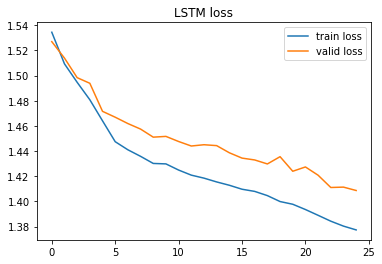

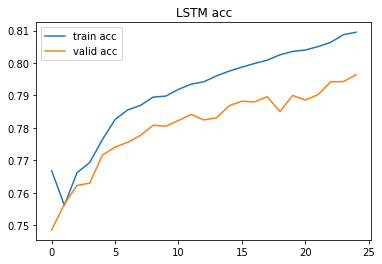

In [ ]:
paras_LSTM = {
    "name": "LSTM",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-4,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

records[paras_LSTM["name"]] = copy.deepcopy(record_default)

vocab_size = len(voc)
num_label = len(id2genre)

model = LSTM(paras_LSTM["hidden_size"], vocab_size, num_label).to(paras_LSTM["device"])
criterion = nn.CrossEntropyLoss().to(paras_LSTM["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=paras_LSTM["learning_rate"])
run_epoch(model, criterion, optimizer, paras_LSTM, run_LSTM)

We can see from the result: LSTM has more stable and better performance than the VRNN.

But at the same time, it has much more parameters in the LSTM because of its complex design, and that results in longer time and more memory to train. So we want to introduce the simplified version to achieve comparable performance but with the advantage of being faster to compute.

| Model | Test Loss | Test Accuracy | Training Time |
| :---: | :---: | :---: | :---: |
| MLP | 1.449 | 77.97% | 33.65 |
| VRNN | 1.496 | 76.21% | 50.69 |
| LSTM | 1.403 | 79.84% | 51.80 |

#### 2.3.4. Gated Recurrent Units

Then **Gated Recurrent Units** (*GRU*) is a streamlined version of the LSTM which retains the key idea of incorporating an internal state and multiplicative gating mechanisms but with the aim of speeding up computation.


In [ ]:
class GRU(nn.Module):

    def __init__(self, hidden_size, vocab_size, num_label):
        super(GRU, self).__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True) 
        self.fc = nn.Linear(hidden_size, num_label)
        self.sm = nn.Softmax(dim=1)
    
    def forward(self, x, hidden):
        
        embed_seq = self.embedding(x)
        output, hidden = self.rnn(embed_seq, hidden)
        
        score = self.fc(output[:, -1, :])
        sig_out = self.sm(score)

        return sig_out, hidden

The main difference between LSTM and GRU is that the three gates in LSTM are replaced by two gates (Reset and Update Gates) in GRU.

$$
R_{t} = \sigma(X_{t}W_{xr} + H_{t-1}W_{hr} + b_{r}) \\
Z_{t} = \sigma(X_{t}W_{xz} + H_{t-1}W_{hz} + b_{z})
$$

GRU_Gate.svg

This is the full architecture of GRU:

GRU.svg

In [ ]:
def run_GRU(model, dataloader, criterion, optimizer, paras, train):
    
    epoch_loss, epoch_acc = 0, 0
    h = torch.zeros(1, batch_size, paras["hidden_size"]).to(paras["device"])

    if train:
        model.train()
        for X, Y in dataloader:

            X, Y = X.to(paras["device"]), Y.to(paras["device"])
            optimizer.zero_grad()
            h = h.detach()

            output, h = model(X, h)
            loss = criterion(output, Y.float())
            acc = accuracy(output, Y)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.detach().item()
            epoch_acc += acc.detach().item()
    else:
        model.eval()
        with torch.no_grad():
            for X, Y in dataloader:

                X, Y = X.to(paras["device"]), Y.to(paras["device"])
                h = h.detach()
                output, h = model(X, h)
                loss = criterion(output, Y.float())
                acc = accuracy(output, Y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, Time: 1.60; Train Loss: 1.528, Train Acc: 76.11%; Valid Loss: 1.527, Valid Acc: 74.87%
Epoch: 1, Time: 3.16; Train Loss: 1.513, Train Acc: 75.50%; Valid Loss: 1.524, Valid Acc: 74.89%
Epoch: 2, Time: 4.69; Train Loss: 1.499, Train Acc: 76.14%; Valid Loss: 1.501, Valid Acc: 76.05%
Epoch: 3, Time: 6.27; Train Loss: 1.483, Train Acc: 76.82%; Valid Loss: 1.495, Valid Acc: 76.26%
Epoch: 4, Time: 7.92; Train Loss: 1.476, Train Acc: 77.11%; Valid Loss: 1.495, Valid Acc: 76.17%
Epoch: 5, Time: 9.68; Train Loss: 1.471, Train Acc: 77.29%; Valid Loss: 1.485, Valid Acc: 76.55%
Epoch: 6, Time: 12.13; Train Loss: 1.451, Train Acc: 78.10%; Valid Loss: 1.452, Valid Acc: 77.98%
Epoch: 7, Time: 13.82; Train Loss: 1.433, Train Acc: 78.83%; Valid Loss: 1.447, Valid Acc: 78.12%
Epoch: 8, Time: 15.38; Train Loss: 1.426, Train Acc: 79.10%; Valid Loss: 1.439, Valid Acc: 78.49%
Epoch: 9, Time: 16.97; Train Loss: 1.421, Train Acc: 79.28%; Valid Loss: 1.438, Valid Acc: 78.45%
Epoch: 10, Time: 18.84; Tr

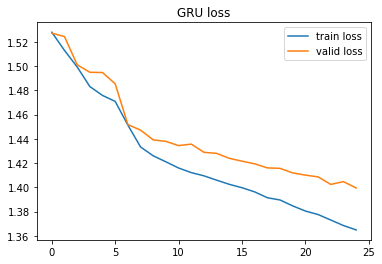

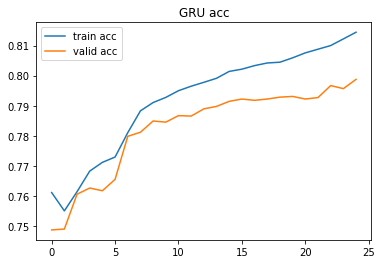

In [ ]:
paras_GRU = {
    "name": "GRU",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-4,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

records[paras_GRU["name"]] = copy.deepcopy(record_default)

vocab_size = len(voc)
num_label = len(id2genre)

model = GRU(paras_GRU["hidden_size"], vocab_size, num_label).to(paras_GRU["device"])
criterion = nn.CrossEntropyLoss().to(paras_GRU["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=paras_GRU["learning_rate"])
run_epoch(model, criterion, optimizer, paras_GRU, run_GRU)

According to the result, it is easy to conclude that GRU has a similar performance to the LSTM but takes less time.

| Model | Test Loss | Test Accuracy | Training Time |
| :---: | :---: | :---: | :---: |
| MLP | 1.449 | 77.97% | 33.65 |
| VRNN | 1.496 | 76.21% | 50.69 |
| LSTM | 1.403 | 79.84% | 51.80 |
| GRU | 1.398 | 79.88% | 47.52 |

#### 2.3.5. Deep RNN

In the VRNN, there is only one hidden layer between the input at any time step and the corresponding output which may be not "deep" enough to capture the information from the sequence. That's why we want to use the **Deep RNN** here to construct RNNs that are deep not only in the time direction but also in the input-to-output direction.

In the Deep RNN, we add additional RNNs on top of the initial standard RNN, where each RNN added is another layer. The hidden state output by the first (bottom) RNN at timestep $t$ will be the input to the RNN above it at timestep. The prediction is then made from the final hidden state of the final (highest) layer.

$$
H_{t}^{(l)} = \phi_{l}(H_{t}^{(l-1)}W_{xh}^{(l)} + H_{t-1}^{(l)}W_{hh}^{(l)} + b_{h}^{(l)}) \\
O_{t} = H_{t}^{(L)}W_{hq} + b_{q}
$$

DeepRNN.svg


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, Time: 3.18; Train Loss: 1.582, Train Acc: 79.28%; Valid Loss: 1.549, Valid Acc: 77.04%
Epoch: 1, Time: 5.39; Train Loss: 1.524, Train Acc: 75.66%; Valid Loss: 1.530, Valid Acc: 74.88%
Epoch: 2, Time: 7.43; Train Loss: 1.516, Train Acc: 75.50%; Valid Loss: 1.530, Valid Acc: 74.85%
Epoch: 3, Time: 9.85; Train Loss: 1.515, Train Acc: 75.50%; Valid Loss: 1.528, Valid Acc: 74.87%
Epoch: 4, Time: 13.07; Train Loss: 1.515, Train Acc: 75.50%; Valid Loss: 1.528, Valid Acc: 74.84%
Epoch: 5, Time: 16.63; Train Loss: 1.514, Train Acc: 75.50%; Valid Loss: 1.526, Valid Acc: 74.88%
Epoch: 6, Time: 19.78; Train Loss: 1.514, Train Acc: 75.50%; Valid Loss: 1.526, Valid Acc: 74.88%
Epoch: 7, Time: 22.80; Train Loss: 1.513, Train Acc: 75.50%; Valid Loss: 1.525, Valid Acc: 74.90%
Epoch: 8, Time: 25.81; Train Loss: 1.513, Train Acc: 75.57%; Valid Loss: 1.525, Valid Acc: 75.00%
Epoch: 9, Time: 28.02; Train Loss: 1.512, Train Acc: 75.65%; Valid Loss: 1.526, Valid Acc: 74.98%
Epoch: 10, Time: 30.42; 

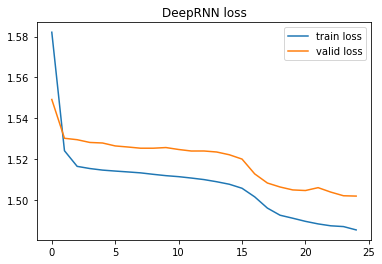

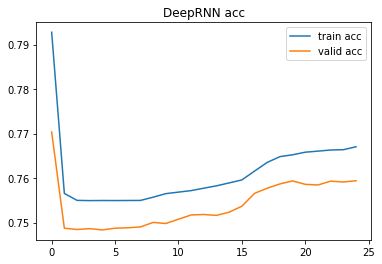

In [ ]:
paras_DeepRNN = {
    "name": "DeepRNN",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-5,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "num_layers": 3,
    "bidirectional": False,
}

records[paras_DeepRNN["name"]] = copy.deepcopy(record_default)

vocab_size = len(voc)
num_label = len(id2genre)

model = VRNN(paras_DeepRNN["hidden_size"], vocab_size, num_label, paras_DeepRNN["num_layers"], paras_DeepRNN["bidirectional"]).to(paras_DeepRNN["device"])
criterion = nn.CrossEntropyLoss().to(paras_DeepRNN["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=paras_DeepRNN["learning_rate"])
run_epoch(model, criterion, optimizer, paras_DeepRNN, run_VRNN)

As it shown in the figures, the stacked RNN improves a little on the problems of this project but not very stable. That may be caused by the limitations of VRNN. In addition, the training takes more time than before because of the increase of the network depth.


| Model | Test Loss | Test Accuracy | Training Time |
| :---: | :---: | :---: | :---: |
| MLP | 1.449 | 77.97% | 33.65 |
| VRNN | 1.496 | 76.21% | 50.69 |
| LSTM | 1.403 | 79.84% | 51.80 |
| GRU | 1.398 | 79.88% | 47.52 |
| Deep RNN | 1.494 | 76.22% | 63.87 |

#### 2.3.6. Bidirectional Recurrent Neural Networks

In the former models, we only use one RNN processing the words in the sentence from the first to the last which considers the leftward context information. Now we want to introduce another RNN to processing the words from the last to the first. Both the forward and backward RNN are called **Bidirectional Recurrent Neural Networks**.

BiRNN.svg

The forward and backward hidden state updates are as follows:

$$
\overrightarrow{H_{t}} = \phi(X_{t}W_{xh}^{(f)} + H_{t-1}W_{hh}^{(f)} + b_{h}^{(f)}) \\
\overleftarrow{H_{t}}  = \phi(X_{t}W_{xh}^{(b)} + H_{t-1}W_{hh}^{(b)} + b_{h}^{(b)})
$$

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, Time: 1.80; Train Loss: 1.557, Train Acc: 77.86%; Valid Loss: 1.538, Valid Acc: 74.88%
Epoch: 1, Time: 3.54; Train Loss: 1.521, Train Acc: 75.50%; Valid Loss: 1.530, Valid Acc: 74.89%
Epoch: 2, Time: 5.27; Train Loss: 1.517, Train Acc: 75.49%; Valid Loss: 1.529, Valid Acc: 74.86%
Epoch: 3, Time: 7.02; Train Loss: 1.516, Train Acc: 75.50%; Valid Loss: 1.528, Valid Acc: 74.88%
Epoch: 4, Time: 8.73; Train Loss: 1.515, Train Acc: 75.50%; Valid Loss: 1.528, Valid Acc: 74.85%
Epoch: 5, Time: 10.47; Train Loss: 1.514, Train Acc: 75.50%; Valid Loss: 1.528, Valid Acc: 74.84%
Epoch: 6, Time: 12.22; Train Loss: 1.514, Train Acc: 75.50%; Valid Loss: 1.527, Valid Acc: 74.85%
Epoch: 7, Time: 13.96; Train Loss: 1.514, Train Acc: 75.50%; Valid Loss: 1.526, Valid Acc: 74.88%
Epoch: 8, Time: 15.69; Train Loss: 1.513, Train Acc: 75.50%; Valid Loss: 1.526, Valid Acc: 74.89%
Epoch: 9, Time: 17.38; Train Loss: 1.513, Train Acc: 75.50%; Valid Loss: 1.526, Valid Acc: 74.88%
Epoch: 10, Time: 19.10; T

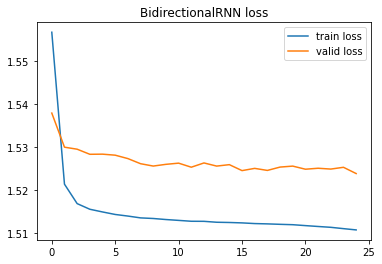

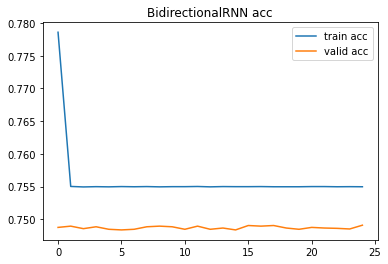

In [ ]:
paras_BidirectionalRNN = {
    "name": "BidirectionalRNN",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-5,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "num_layers": 1,
    "bidirectional": True,
}

records[paras_BidirectionalRNN["name"]] = copy.deepcopy(record_default)

vocab_size = len(voc)
num_label = len(id2genre)

model = VRNN(paras_BidirectionalRNN["hidden_size"], vocab_size, num_label, paras_BidirectionalRNN["num_layers"], paras_BidirectionalRNN["bidirectional"]).to(paras_BidirectionalRNN["device"])
criterion = nn.CrossEntropyLoss().to(paras_BidirectionalRNN["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=paras_BidirectionalRNN["learning_rate"])
run_epoch(model, criterion, optimizer, paras_BidirectionalRNN, run_VRNN)

As with the Deep RNN, the Bidirectional RNN also has unstable performance. We can find that the loss curves show a bit of an overfitting tendency which we will demonstrate its solutions later.

| Model | Test Loss | Test Accuracy | Training Time |
| :---: | :---: | :---: | :---: |
| MLP | 1.449 | 77.97% | 33.65 |
| VRNN | 1.496 | 76.21% | 50.69 |
| LSTM | 1.403 | 79.84% | 51.80 |
| GRU | 1.398 | 79.88% | 47.52 |
| Deep RNN | 1.494 | 76.22% | 63.87 |
| Bidirectional RNN | 1.515 | 75.28% | 43.47 |

#### 2.3.7. Transformer

The above are the common RNN variants, but even the LSTM or GRU can not learn from very long sequences yet because of the non-linear dynamic systems. So we introduce the attention mechanism here which is helpful when dealing with long sequences. In former models, the very long sequence requires to be memorized and represented by a single vectors while we distribute the memorization load over each word with attention. That solves the limitation of long-term dependencies in RNNs: any word in the target sequence communicates with any word in the source sequence.

This figure shows the general way to compute the attention score.

Attention.svg

Transformer is one of the classic network architecture with attention machnism. This is the full figure of it.

transformer.svg

In [ ]:
class Transformer(nn.Module):

    def __init__(self, hidden_size, vocab_size, num_label):
        super(Transformer, self).__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder_layer = nn.TransformerEncoderLayer(hidden_size, 5, batch_first=True) 
        self.rnn = nn.TransformerEncoder(self.encoder_layer, num_layers=3)

        self.fc = nn.Linear(hidden_size * 50, num_label)
        self.sm = nn.Softmax(dim=1)
    
    def forward(self, x):
        embed_seq = self.embedding(x)
        output = self.rnn(embed_seq)
        score = self.fc(output.reshape(batch_size, -1))
        sig_out = self.sm(score)

        return sig_out

In [ ]:
def run_Transformer(model, dataloader, criterion, optimizer, paras, train):
    
    epoch_loss, epoch_acc = 0, 0

    if train:
        model.train()
        for X, Y in dataloader:

            X, Y = X.to(paras["device"]), Y.to(paras["device"])
            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y.float())
            acc = accuracy(output, Y)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.detach().item()
            epoch_acc += acc.detach().item()
    else:
        model.eval()
        with torch.no_grad():
            for X, Y in dataloader:

                X, Y = X.to(paras["device"]), Y.to(paras["device"])

                output = model(X)
                loss = criterion(output, Y.float())
                acc = accuracy(output, Y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, Time: 9.01; Train Loss: 1.517, Train Acc: 75.52%; Valid Loss: 1.532, Valid Acc: 74.89%
Epoch: 1, Time: 18.39; Train Loss: 1.508, Train Acc: 75.53%; Valid Loss: 1.509, Valid Acc: 75.23%
Epoch: 2, Time: 29.19; Train Loss: 1.450, Train Acc: 77.99%; Valid Loss: 1.426, Valid Acc: 78.58%
Epoch: 3, Time: 38.54; Train Loss: 1.389, Train Acc: 80.49%; Valid Loss: 1.418, Valid Acc: 79.09%
Epoch: 4, Time: 48.54; Train Loss: 1.364, Train Acc: 81.59%; Valid Loss: 1.392, Valid Acc: 80.39%
Epoch: 5, Time: 57.36; Train Loss: 1.341, Train Acc: 82.62%; Valid Loss: 1.379, Valid Acc: 80.84%
Epoch: 6, Time: 66.16; Train Loss: 1.319, Train Acc: 83.60%; Valid Loss: 1.365, Valid Acc: 81.53%
Epoch: 7, Time: 75.01; Train Loss: 1.301, Train Acc: 84.33%; Valid Loss: 1.364, Valid Acc: 81.44%
Epoch: 8, Time: 84.54; Train Loss: 1.279, Train Acc: 85.30%; Valid Loss: 1.351, Valid Acc: 81.93%
Epoch: 9, Time: 93.48; Train Loss: 1.258, Train Acc: 86.21%; Valid Loss: 1.339, Valid Acc: 82.54%
Epoch: 10, Time: 102.

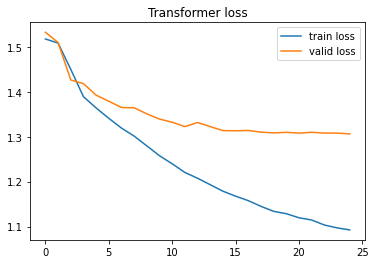

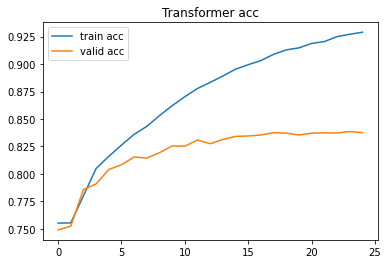

In [ ]:
paras_Transformer = {
    "name": "Transformer",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-4,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

records[paras_Transformer["name"]] = copy.deepcopy(record_default)

vocab_size = len(voc)
num_label = len(id2genre)

model = Transformer(paras_Transformer["hidden_size"], vocab_size, num_label).to(paras_Transformer["device"])
criterion = nn.CrossEntropyLoss().to(paras_Transformer["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=paras_Transformer["learning_rate"])
run_epoch(model, criterion, optimizer, paras_Transformer, run_Transformer)

We can see from the figure: the Transformer achieves the best performance for now. That indicates that its ability to learn from long sequences does make sense.

| Model | Test Loss | Test Accuracy | Training Time |
| :---: | :---: | :---: | :---: |
| MLP | 1.449 | 77.97% | 33.65 |
| VRNN | 1.496 | 76.21% | 50.69 |
| LSTM | 1.403 | 79.84% | 51.80 |
| GRU | 1.398 | 79.88% | 47.52 |
| Deep RNN | 1.494 | 76.22% | 63.87 |
| Bidirectional RNN | 1.515 | 75.28% | 43.47 |
| Transformer | 1.311 | 83.53% | 227.26 |

#### 2.3.8. Bidirectional Encoder Representations from Transformers

In this part, we introduce one of the Transformer variants named **Bidirectional Encoder Representations from Transformers** (*BERT*) which encodes context bidirectionally and requires minimal architecture changes for a wide range of natural language processing tasks. Using a pretrained transformer encoder, BERT is able to represent any token based on its bidirectional context.

IHere we choose to use XtremeDistilTransformers which is a distilled task-agnostic transformer model that leverages task transfer for learning a small universal model that can be applied to arbitrary tasks and languages. Compared to the other Transformer and BERT variants, it's much faster and smaller but keeps good performance.

In [ ]:
def run_Bert(model, dataloader, criterion, optimizer, paras, train):
    
    epoch_loss, epoch_acc = 0, 0
    h = torch.zeros(1, batch_size, paras["hidden_size"]).to(paras["device"])

    if train:
        model.train()
        for X, Y in dataloader:

            X, Y = X.to(paras["device"]), Y.to(paras["device"])
            optimizer.zero_grad()
            h = h.detach()

            output = model(X)
            loss = criterion(output[0], Y.float())
            acc = accuracy(output[0], Y)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.detach().item()
            epoch_acc += acc.detach().item()
    else:
        model.eval()
        with torch.no_grad():
            for X, Y in dataloader:

                X, Y = X.to(paras["device"]), Y.to(paras["device"])
                h = h.detach()
                output = model(X)
                loss = criterion(output[0], Y.float())
                acc = accuracy(output[0], Y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 34.2 MB/s 
     |████████████████████████████████| 7.6 MB 9.8 MB/s 
     |████████████████████████████████| 163 kB 71.5 MB/s 


Downloading:   0%|          | 0.00/525 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.0M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/xtremedistil-l6-h256-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, Time: 25.77; Train Loss: 1.468, Train Acc: 66.19%; Valid Loss: 1.323, Valid Acc: 57.17%
Epoch: 1, Time: 49.07; Train Loss: 1.274, Train Acc: 49.02%; Valid Loss: 1.253, Valid Acc: 45.45%
Epoch: 2, Time: 71.90; Train Loss: 1.218, Train Acc: 41.48%; Valid Loss: 1.268, Valid Acc: 38.72%
Epoch: 3, Time: 94.66; Train Loss: 1.162, Train Acc: 38.80%; Valid Loss: 1.176, Valid Acc: 36.20%
Epoch: 4, Time: 119.24; Train Loss: 1.123, Train Acc: 36.38%; Valid Loss: 1.163, Valid Acc: 35.46%
Epoch: 5, Time: 142.28; Train Loss: 1.094, Train Acc: 33.24%; Valid Loss: 1.132, Valid Acc: 35.97%
Epoch: 6, Time: 165.27; Train Loss: 1.056, Train Acc: 30.07%; Valid Loss: 1.116, Valid Acc: 29.45%
Epoch: 7, Time: 188.25; Train Loss: 0.987, Train Acc: 27.81%; Valid Loss: 1.083, Valid Acc: 25.14%
Epoch: 8, Time: 211.36; Train Loss: 0.930, Train Acc: 25.46%; Valid Loss: 1.076, Valid Acc: 22.82%
Epoch: 9, Time: 239.09; Train Loss: 0.890, Train Acc: 23.34%; Valid Loss: 1.059, Valid Acc: 18.80%
Epoch: 10, Tim

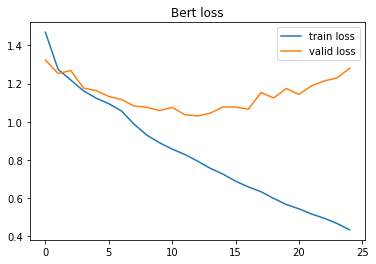

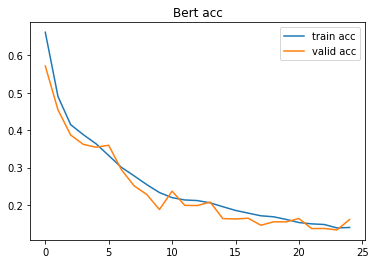

In [ ]:
from transformers import BertForSequenceClassification

paras_Bert = {
    "name": "Bert",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-4,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

records[paras_Bert["name"]] = copy.deepcopy(record_default)

vocab_size = len(voc)
num_label = len(id2genre)

model = BertForSequenceClassification.from_pretrained("microsoft/xtremedistil-l6-h256-uncased", num_labels=num_label).to(paras_Bert["device"])
criterion = nn.CrossEntropyLoss().to(paras_Bert["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=paras_Bert["learning_rate"])
run_epoch(model, criterion, optimizer, paras_Bert, run_Bert)

We can find that BERT has low train loss but bad accuracy on the test dataset. This is probably because its structure is too complex for this problem.

| Model | Test Loss | Test Accuracy | Training Time |
| :---: | :---: | :---: | :---: |
| MLP | 1.449 | 77.97% | 33.65 |
| VRNN | 1.496 | 76.21% | 50.69 |
| LSTM | 1.403 | 79.84% | 51.80 |
| GRU | 1.398 | 79.88% | 47.52 |
| Deep RNN | 1.494 | 76.22% | 63.87 |
| Bidirectional RNN | 1.515 | 75.28% | 43.47 |
| Transformer | 1.311 | 83.53% | 227.26 |
| Bert | 1.016 | 19.72% | 584.48 |

Finally, we plot the loss and accuracy curve of all models together. 

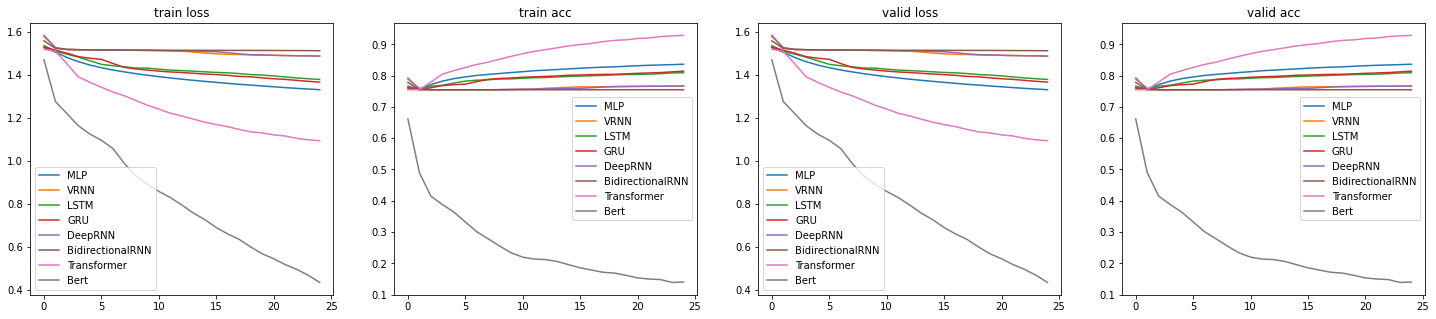

In [ ]:
def plot_mul(items=records.keys()):
    plt.figure(figsize=(25, 5))

    for i, a in enumerate(["train", "valid"]):
        for j, b in enumerate(["loss", "acc"]):
            plt.subplot(1, 4, i * 2 + j + 1)
            for k in items:
                plt.plot(records[k]["train_" + b], label=f"{k}")

            plt.legend()
            plt.title(f"{a} {b}")
    plt.show()

plot_mul(["MLP", "VRNN", "LSTM", "GRU", "DeepRNN", "BidirectionalRNN", "Transformer", "Bert"])

### 2.4. Fine Tuning

In this section, we want to explore the effect of different model parameters on the performance.

#### 2.4.1. Initialization

Weight initialization is a procedure to set the weights of a neural network to small random values that define the starting point for the optimization (learning or training) of the neural network model.

Each time, a neural network is initialized with a different set of weights, resulting in a different starting point for the optimization process, and potentially resulting in a different final set of weights with different performance characteristics.

We choose 3 ways to initialize weights of GRU part: fill the weights with values drawn from the uniform distribution $U(a, b)$, normal distribution $N(mean, std^{2})$ and scalar value 0.

Init: Uniform


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 66.71, Test Loss: 1.407, Test Acc: 79.44%
Init: Normal


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 40.27, Test Loss: 1.393, Test Acc: 80.11%
Init: Zero


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 42.42, Test Loss: 1.391, Test Acc: 80.23%


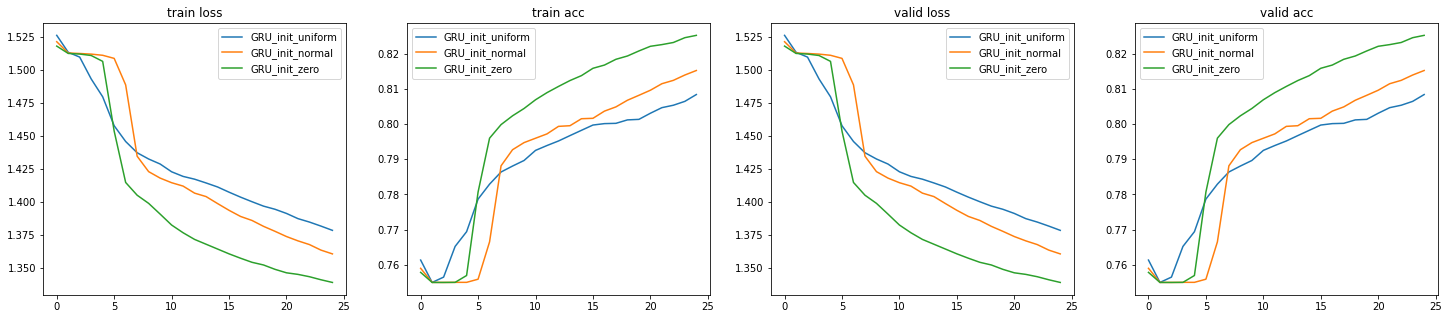

In [ ]:
paras_GRU_init = {
    "name": "GRU_init",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-4,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

vocab_size = len(voc)
num_label = len(id2genre)

model = GRU(paras_GRU_init["hidden_size"], vocab_size, num_label).to(paras_GRU_init["device"])
criterion = nn.CrossEntropyLoss().to(paras_GRU_init["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=paras_GRU_init["learning_rate"])

print("Init: Uniform")
nn.init.uniform_(model.rnn.weight_hh_l0, -0.05, 0.05)
nn.init.uniform_(model.rnn.weight_ih_l0, -0.05, 0.05)
nn.init.uniform_(model.rnn.bias_ih_l0, -0.05, 0.05)
nn.init.uniform_(model.rnn.bias_hh_l0, -0.05, 0.05)

paras_GRU_init["name"] = "GRU_init_uniform"
records[paras_GRU_init["name"]] = copy.deepcopy(record_default)
run_epoch(model, criterion, optimizer, paras_GRU_init, run_GRU, False, False)


print("Init: Normal")
nn.init.normal_(model.rnn.weight_hh_l0, 0, 0.01)
nn.init.normal_(model.rnn.weight_ih_l0, 0, 0.01)
nn.init.normal_(model.rnn.bias_ih_l0, 0, 0.01)
nn.init.normal_(model.rnn.bias_hh_l0, 0, 0.01)

paras_GRU_init["name"] = "GRU_init_normal"
records[paras_GRU_init["name"]] = copy.deepcopy(record_default)
run_epoch(model, criterion, optimizer, paras_GRU_init, run_GRU, False, False)

print("Init: Zero")

nn.init.zeros_(model.rnn.weight_hh_l0)
nn.init.zeros_(model.rnn.weight_ih_l0)
nn.init.zeros_(model.rnn.bias_ih_l0)
nn.init.zeros_(model.rnn.bias_hh_l0)

paras_GRU_init["name"] = "GRU_init_zero"
records[paras_GRU_init["name"]] = copy.deepcopy(record_default)
run_epoch(model, criterion, optimizer, paras_GRU_init, run_GRU, False, False)

plot_mul(["GRU_init_uniform", "GRU_init_normal", "GRU_init_zero"])

In our experiments, these three ways don't show obvious difference while initializing all weights to the value 0 is bad generally as the optimization algorithm results in some asymmetry in the error gradient to begin searching effectively.

#### 2.4.2. Learning Rate

The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

Learning Rate: 0.01


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 42.12, Test Loss: 1.523, Test Acc: 75.29%
Learning Rate: 0.001


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 39.49, Test Loss: 1.514, Test Acc: 75.35%
Learning Rate: 0.0001


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 39.28, Test Loss: 1.517, Test Acc: 75.15%
Learning Rate: 1e-05


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 41.44, Test Loss: 1.518, Test Acc: 75.21%


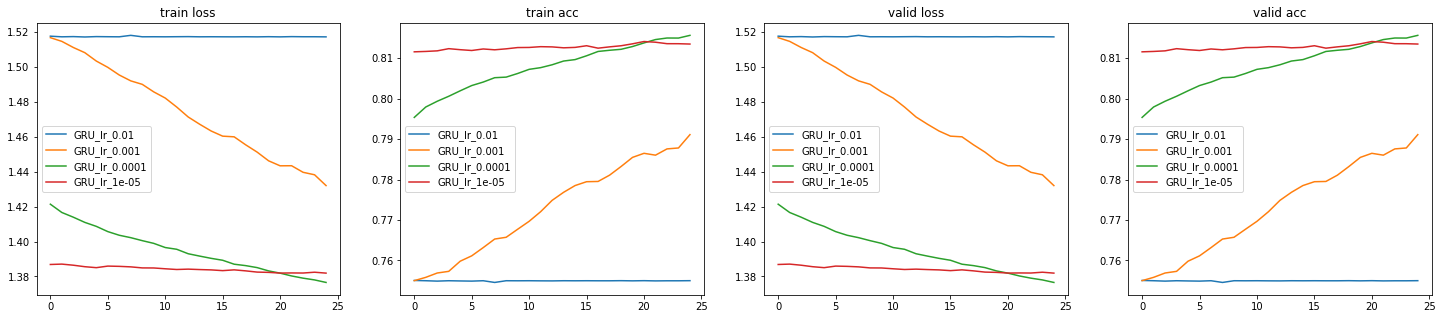

In [ ]:
paras_GRU_lr = {
    "name": "GRU_lr",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-4,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

vocab_size = len(voc)
num_label = len(id2genre)

model =GRU(paras_GRU_lr["hidden_size"], vocab_size, num_label).to(paras_GRU_lr["device"])
criterion = nn.CrossEntropyLoss().to(paras_GRU_lr["device"])
lrs = [0.01, 0.001, 0.0001, 0.00001]

for lr in lrs:

    print(f"Learning Rate: {lr}")
    paras_GRU_lr["name"] = f"GRU_lr_{lr}"
    paras_GRU_lr["learning_rate"] = lr

    records[paras_GRU_lr["name"]] = copy.deepcopy(record_default)
    optimizer = torch.optim.Adam(model.parameters(), lr=paras_GRU_lr["learning_rate"])
    run_epoch(model, criterion, optimizer, paras_GRU_lr, run_GRU, False, False)

plot_mul([f"GRU_lr_{i}" for i in lrs])

As we expect, the low learning rate (1e-5) makes it hard to converge while the high learning rate (1e-2) leads to unchanged even diverge.

#### 2.4.3. Optimizer

Optimizers are algorithms or methods used to change the attributes of your neural network such as weights and learning rate in order to reduce the losses.

We choose 3 common ways here to see the effect of them on the model performance:

1. Stochastic Gradient Descent (SGD): At each iteration, uniformly sample an index for data examples at random, and compute the gradient  to update weights.
2. Adadelta: Use the rate of change in the parameters itself to adapt the learning rate.
2. Adam: Use exponential weighted moving averages to obtain an estimate of both the momentum and also the second moment of the gradient.

Optimizer: Adam


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 40.07, Test Loss: 1.496, Test Acc: 76.30%
Optimizer: SGD


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 32.80, Test Loss: 1.603, Test Acc: 80.00%
Optimizer: Adadelta


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 41.99, Test Loss: 1.609, Test Acc: 80.00%


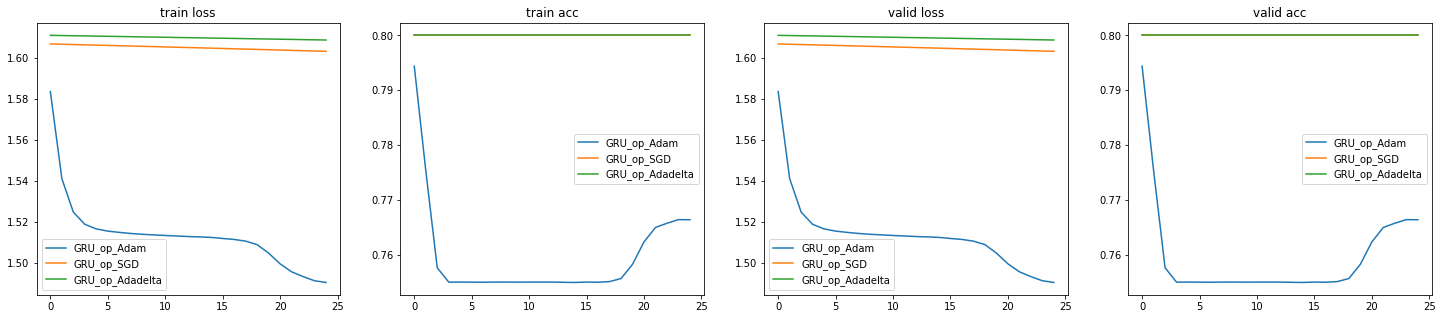

In [ ]:
paras_GRU_op = {
    "name": "GRU_op",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-5,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

vocab_size = len(voc)
num_label = len(id2genre)

criterion = nn.CrossEntropyLoss().to(paras_GRU_op["device"])

print("Optimizer: Adam")
paras_GRU_op["name"] = "GRU_op_Adam"
records[paras_GRU_op["name"]] = copy.deepcopy(record_default)
model = GRU(paras_GRU_op["hidden_size"], vocab_size, num_label).to(paras_GRU_op["device"])

optimizer = torch.optim.Adam(model.parameters(), lr=paras_GRU_op["learning_rate"])

run_epoch(model, criterion, optimizer, paras_GRU_op, run_GRU, False, False)

print("Optimizer: SGD")
paras_GRU_op["name"] = "GRU_op_SGD"
records[paras_GRU_op["name"]] = copy.deepcopy(record_default)
model =GRU(paras_GRU_op["hidden_size"], vocab_size, num_label).to(paras_GRU_op["device"])

optimizer = torch.optim.SGD(model.parameters(), lr=paras_GRU_op["learning_rate"])

run_epoch(model, criterion, optimizer, paras_GRU_op, run_GRU, False, False)

print("Optimizer: Adadelta")
paras_GRU_op["name"] = "GRU_op_Adadelta"
records[paras_GRU_op["name"]] = copy.deepcopy(record_default)
model = GRU(paras_GRU_op["hidden_size"], vocab_size, num_label).to(paras_GRU_op["device"])

optimizer = torch.optim.Adadelta(model.parameters(), lr=paras_GRU_op["learning_rate"])

run_epoch(model, criterion, optimizer, paras_GRU_op, run_GRU, False, False)

plot_mul(["GRU_op_Adam", "GRU_op_SGD", "GRU_op_Adadelta"])

#### 2.4.4. Hidden Size

Hidden size directly affects the complexity of the model. Generally, a larger hidden size brings a more complex model which may make it more effective to learn from data but it also adds the risk of overfitting and training time.

Hidden Size: 20


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 41.21, Test Loss: 1.521, Test Acc: 75.25%
Hidden Size: 50


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 39.69, Test Loss: 1.518, Test Acc: 75.26%
Hidden Size: 100


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 39.36, Test Loss: 1.503, Test Acc: 76.06%
Hidden Size: 200


  0%|          | 0/25 [00:00<?, ?it/s]

Time: 60.50, Test Loss: 1.485, Test Acc: 76.69%


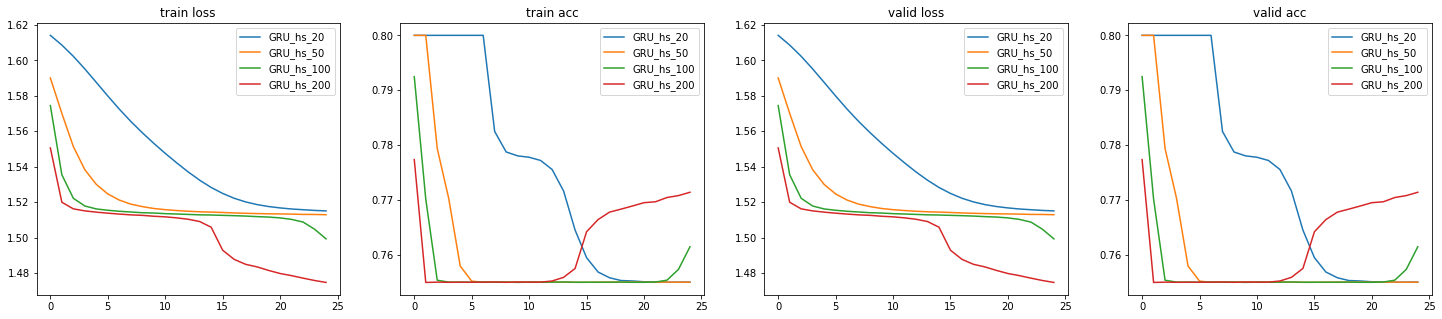

In [ ]:
paras_GRU_hs = {
    "name": "GRU_hs",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-5,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

vocab_size = len(voc)
num_label = len(id2genre)

criterion = nn.CrossEntropyLoss().to(paras_GRU_hs["device"])
hss = [20, 50, 100, 200]

for hs in hss:

    print(f"Hidden Size: {hs}")
    paras_GRU_hs["name"] = f"GRU_hs_{hs}"
    paras_GRU_hs["hidden_size"] = hs

    records[paras_GRU_hs["name"]] = copy.deepcopy(record_default)
    
    model = GRU(paras_GRU_hs["hidden_size"], vocab_size, num_label).to(paras_GRU_hs["device"])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=paras_GRU_hs["learning_rate"])
    run_epoch(model, criterion, optimizer, paras_GRU_hs, run_GRU, False, False)

plot_mul([f"GRU_hs_{i}" for i in hss])

We can see from the figures: as the hidden size increases, the test loss is smaller and the accuracy is higher, but at the same time the training time becomes more.

### 2.5. Regularization

We have found that the model may suffer from the overfit problem and that leads to the bad accuracy in the test dataset. So we focus on the regularization techniques in this section.

**Regularization** can be lossely defined as any form of modification to a learning algorithm intended to reduce its generalization error but not training error.

#### 2.5.1. Weight Decay

**Weight Decay** ($L_{2}$ Regularization) is a regularization technique applied to the weights of a neural network. It adds an extra term in the objective called parameter norm penalties. The loss function is computed as:

$$
L_{new}(w) = L_{original}(w) + \lambda w^{T}w
$$

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, Time: 1.84; Train Loss: 1.559, Train Acc: 78.02%; Valid Loss: 1.537, Valid Acc: 74.89%
Epoch: 1, Time: 3.67; Train Loss: 1.521, Train Acc: 75.50%; Valid Loss: 1.530, Valid Acc: 74.85%
Epoch: 2, Time: 5.55; Train Loss: 1.516, Train Acc: 75.50%; Valid Loss: 1.528, Valid Acc: 74.89%
Epoch: 3, Time: 7.38; Train Loss: 1.515, Train Acc: 75.50%; Valid Loss: 1.529, Valid Acc: 74.85%
Epoch: 4, Time: 9.22; Train Loss: 1.515, Train Acc: 75.50%; Valid Loss: 1.527, Valid Acc: 74.88%
Epoch: 5, Time: 11.17; Train Loss: 1.514, Train Acc: 75.50%; Valid Loss: 1.527, Valid Acc: 74.88%
Epoch: 6, Time: 15.16; Train Loss: 1.514, Train Acc: 75.50%; Valid Loss: 1.526, Valid Acc: 74.89%
Epoch: 7, Time: 17.32; Train Loss: 1.514, Train Acc: 75.50%; Valid Loss: 1.526, Valid Acc: 74.90%
Epoch: 8, Time: 19.11; Train Loss: 1.514, Train Acc: 75.50%; Valid Loss: 1.526, Valid Acc: 74.86%
Epoch: 9, Time: 20.88; Train Loss: 1.513, Train Acc: 75.50%; Valid Loss: 1.526, Valid Acc: 74.88%
Epoch: 10, Time: 22.70; T

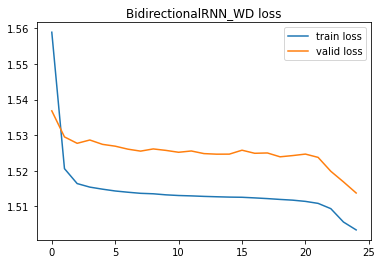

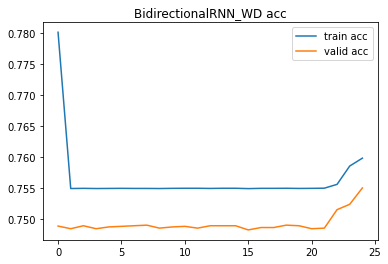

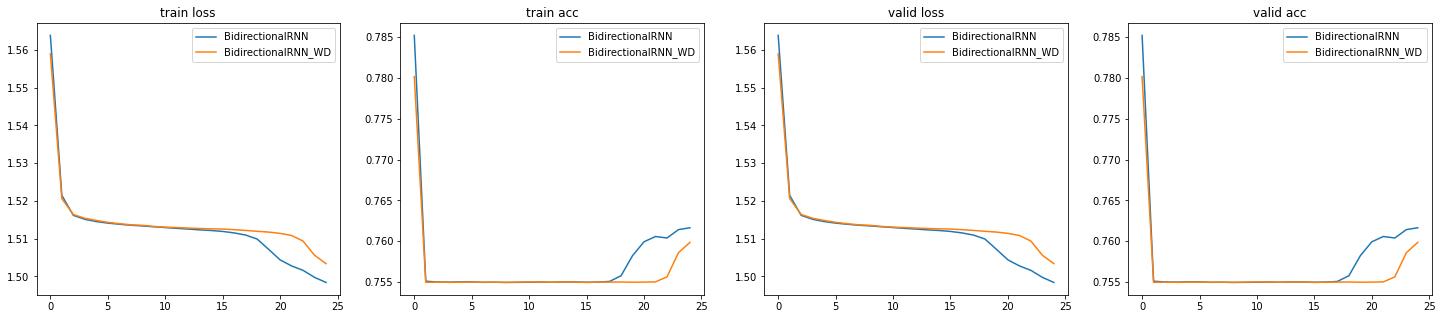

In [ ]:
paras_BidirectionalRNN_WD = {
    "name": "BidirectionalRNN_WD",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-5,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "num_layers": 1,
    "bidirectional": True,
}

records[paras_BidirectionalRNN_WD["name"]] = copy.deepcopy(record_default)

vocab_size = len(voc)
num_label = len(id2genre)

model = VRNN(paras_BidirectionalRNN_WD["hidden_size"], vocab_size, num_label, paras_BidirectionalRNN_WD["num_layers"], paras_BidirectionalRNN_WD["bidirectional"]).to(paras_BidirectionalRNN_WD["device"])
criterion = nn.CrossEntropyLoss().to(paras_BidirectionalRNN_WD["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=paras_BidirectionalRNN_WD["learning_rate"], weight_decay=0.0001)
run_epoch(model, criterion, optimizer, paras_BidirectionalRNN_WD, run_VRNN)

plot_mul(["BidirectionalRNN", "BidirectionalRNN_WD"])

| Model | Test Loss | Test Accuracy | Training Time |
| :---: | :---: | :---: | :---: |
| Bidirectional RNN | 1.515 | 75.28% | 43.47 |
| Bidirectional RNN (Weight Decay)| 1.508 | 75.92% | 47.51 |

From the final result, we can find that weight decay does help to reduce generalization error.

#### 2.5.2. Dropout

Dropout is a computationally cheap and remarkably effective regularization method. By randomly dropping out nodes during training, a single model can be used to simulate having a large number of different network architectures.

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, Time: 2.08; Train Loss: 1.571, Train Acc: 78.68%; Valid Loss: 1.541, Valid Acc: 75.37%
Epoch: 1, Time: 4.11; Train Loss: 1.521, Train Acc: 75.57%; Valid Loss: 1.530, Valid Acc: 74.87%
Epoch: 2, Time: 6.15; Train Loss: 1.516, Train Acc: 75.50%; Valid Loss: 1.529, Valid Acc: 74.88%
Epoch: 3, Time: 8.18; Train Loss: 1.515, Train Acc: 75.50%; Valid Loss: 1.529, Valid Acc: 74.87%
Epoch: 4, Time: 10.22; Train Loss: 1.515, Train Acc: 75.50%; Valid Loss: 1.528, Valid Acc: 74.88%
Epoch: 5, Time: 12.24; Train Loss: 1.514, Train Acc: 75.50%; Valid Loss: 1.527, Valid Acc: 74.88%
Epoch: 6, Time: 14.28; Train Loss: 1.514, Train Acc: 75.50%; Valid Loss: 1.527, Valid Acc: 74.89%
Epoch: 7, Time: 16.34; Train Loss: 1.513, Train Acc: 75.54%; Valid Loss: 1.526, Valid Acc: 74.94%
Epoch: 8, Time: 18.37; Train Loss: 1.512, Train Acc: 75.60%; Valid Loss: 1.525, Valid Acc: 75.14%
Epoch: 9, Time: 20.42; Train Loss: 1.512, Train Acc: 75.70%; Valid Loss: 1.526, Valid Acc: 74.92%
Epoch: 10, Time: 22.55; 

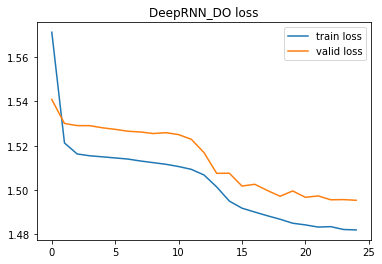

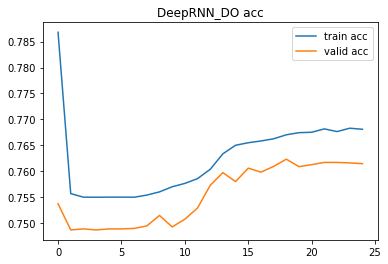

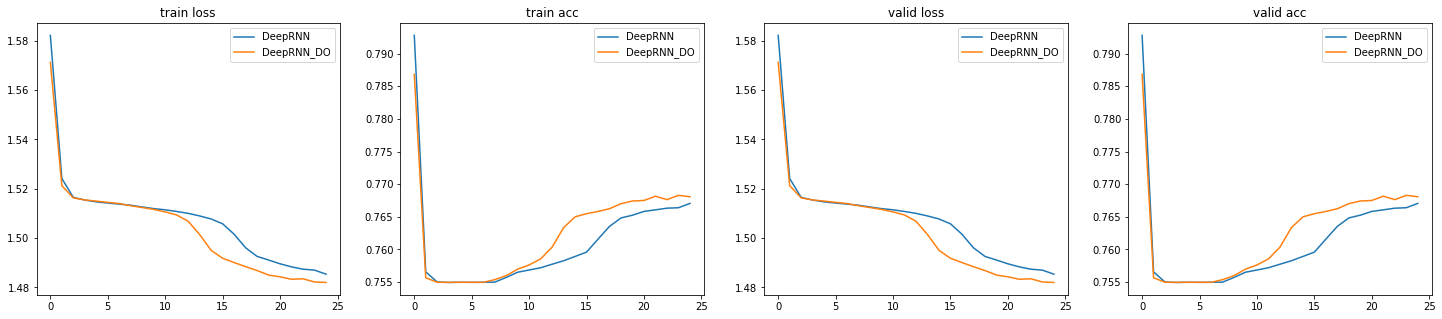

In [ ]:
paras_DeepRNN_DO = {
    "name": "DeepRNN_DO",
    "num_epoch": 25,
    "hidden_size": 100,
    "learning_rate": 1e-5,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "num_layers": 3,
    "bidirectional": False,
    "dropout": 0.1
}

records[paras_DeepRNN_DO["name"]] = copy.deepcopy(record_default)

vocab_size = len(voc)
num_label = len(id2genre)

model = VRNN(paras_DeepRNN_DO["hidden_size"], vocab_size, num_label, paras_DeepRNN_DO["num_layers"], paras_DeepRNN_DO["bidirectional"], paras_DeepRNN_DO["dropout"]).to(paras_DeepRNN_DO["device"])
criterion = nn.CrossEntropyLoss().to(paras_DeepRNN_DO["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=paras_DeepRNN_DO["learning_rate"])
run_epoch(model, criterion, optimizer, paras_DeepRNN_DO, run_VRNN)

plot_mul(["DeepRNN", "DeepRNN_DO"])

| Model | Test Loss | Test Accuracy | Training Time |
| :---: | :---: | :---: | :---: |
| Bidirectional RNN | 1.515 | 75.28% | 43.47 |
| Bidirectional RNN (Dropout)| 1.495 | 76.25% | 58.30 | 

We can see that dropout imporves the final performance a little.